In [69]:
from pathlib import Path
from itertools import combinations

import pandas as pd
pd.set_option("display.max_columns", None)
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [3]:
#DATA_DIR = Path.cwd().resolve().parents[1]

In [6]:
df = pd.read_parquet("data/01_raw/movies_dataset_2025-05-07.parquet")

In [7]:
cat_cols = ["original_language", "source", "status"]
df[cat_cols] = df[cat_cols].astype("category")

In [8]:
df.sample(5)

,adult,backdrop_path,genre_ids,id,original_language,original_title,overview,popularity,poster_path,release_date,title,video,vote_average,vote_count,source,entry_date,was_ingested,is_popular,runtime,budget,revenue,status,tagline,genres,spoken_languages,keywords
4171,False,/bCmbmvhEXREIJLihDQnSL7YfrtE.jpg,[16],1058906,ja,TVシリーズ特別編集版 名探偵コナン 灰原哀物語 黒鉄のミステリートレイン,Ai Haibara (autonym Shiho Miyano a.k.a. Sherry...,1.1163,/mqYvJXLdsLp3Qsmej0ekOqBrzow.jpg,2023-01-06,Detective Conan: The Story of Ai Haibara: Blac...,False,6.600,14,exploratory,2025-01-12,False,False,91,0,0,Released,,[Animación],[日本語],[edited from tv series]
4999,False,/dVUBz5Fe07TsA5M4KFjWjjnM99j.jpg,[18],962782,fr,Libre Garance !,It is the summer of 1982. Garance is eleven ye...,0.1079,/tmEYK2n39YhjqJ4RJjXCUAAB4M7.jpg,2022-09-21,Libre Garance !,False,5.900,12,exploratory,2025-05-03,False,False,97,0,0,Released,,[Drama],[Français],[]
4698,False,/lUPz9zW0uf0bHfYsRRID8RtBHEU.jpg,"[18, 36]",457232,en,Lamborghini: The Man Behind the Legend,Follow the launch of Lamborghini’s career as a...,5.1030,/RKgnYLhCNGCUkrhiCRrs40rEHe.jpg,2022-11-17,Lamborghini: The Man Behind the Legend,False,6.398,630,exploratory,2025-03-11,False,False,97,1709686,0,Released,Una Película de Bobby Moresco,"[Drama, Historia]",[English],"[based on novel or book, biography, historical..."
5650,False,/zN0igphhxZv9OgapkE3y8uMMVpf.jpg,"[35, 10749]",790806,de,Liebesdings,"Red carpet, spotlights, screaming fans, photo-...",0.5604,/8nlij46VZsHku2gWQMTO6BQv31e.jpg,2022-07-07,Love Thing,False,4.800,24,exploratory,2025-04-22,False,False,99,0,0,Released,,"[Comedia, Romance]",[Deutsch],[]
5180,False,/xp6ZNacNFf9GmJe648fUqfbdyph.jpg,"[53, 18]",852427,fr,Kompromat,"Mathieu, a member of the French institute in I...",1.4232,/6OimOLolZ94sy0KVmimRxqfxy8.jpg,2022-09-07,Kompromat,False,6.364,254,exploratory,2025-02-15,False,False,127,0,4283431,Released,,"[Suspense, Drama]","[Français, English, Pусский]",[]


In [19]:
df["video"].value_counts()

,count
video,
False,8000


In [21]:
df["adult"].value_counts()

,count
adult,
False,8000


In [20]:
df["source"].value_counts()

,count
source,
exploratory,8000


In [23]:
df["was_ingested"].value_counts()

,count
was_ingested,
False,8000


In [25]:
df["status"].value_counts()

,count
status,
Released,8000


# Some conclusions from a first glance
- `overview` and `tagline` columns would be hard to analyze and feed to the model, due to it's free text nature. This column will bring low to none value with this initial state, however NLP technices like NER could be applied to the text in order of extracting 'mentioned entities'. For now this column won't be taken into account for the analysis.   
- Id columns like: `genre_ids` and `id` won't be taken into account either.
- `original_title`, `title` and `poster_path` columns won't be taken.
- `source`, `adult`, `was_ingested`, `status` and `video` columns will be discarded too as they present a constant behaviour.

In [35]:
analyze_cols: list[str] = ['original_language', 'popularity', 'release_date', 'vote_average',
       'vote_count', 'entry_date', 'is_popular', 'runtime', 'budget',
       'revenue', 'genres', 'spoken_languages', 'keywords']

df = df[analyze_cols]

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   original_language  8000 non-null   category      
 1   popularity         8000 non-null   float64       
 2   release_date       8000 non-null   object        
 3   vote_average       8000 non-null   float64       
 4   vote_count         8000 non-null   int64         
 5   entry_date         8000 non-null   datetime64[ns]
 6   is_popular         8000 non-null   bool          
 7   runtime            8000 non-null   int64         
 8   budget             8000 non-null   int64         
 9   revenue            8000 non-null   int64         
 10  genres             8000 non-null   object        
 11  spoken_languages   8000 non-null   object        
 12  keywords           8000 non-null   object        
dtypes: bool(1), category(1), datetime64[ns](1), float64(2), int64(4

# Numerical vs. numerical

In [39]:
num_cols: list[str] = ['popularity', 'vote_average','vote_count', 'runtime', 'budget','revenue']

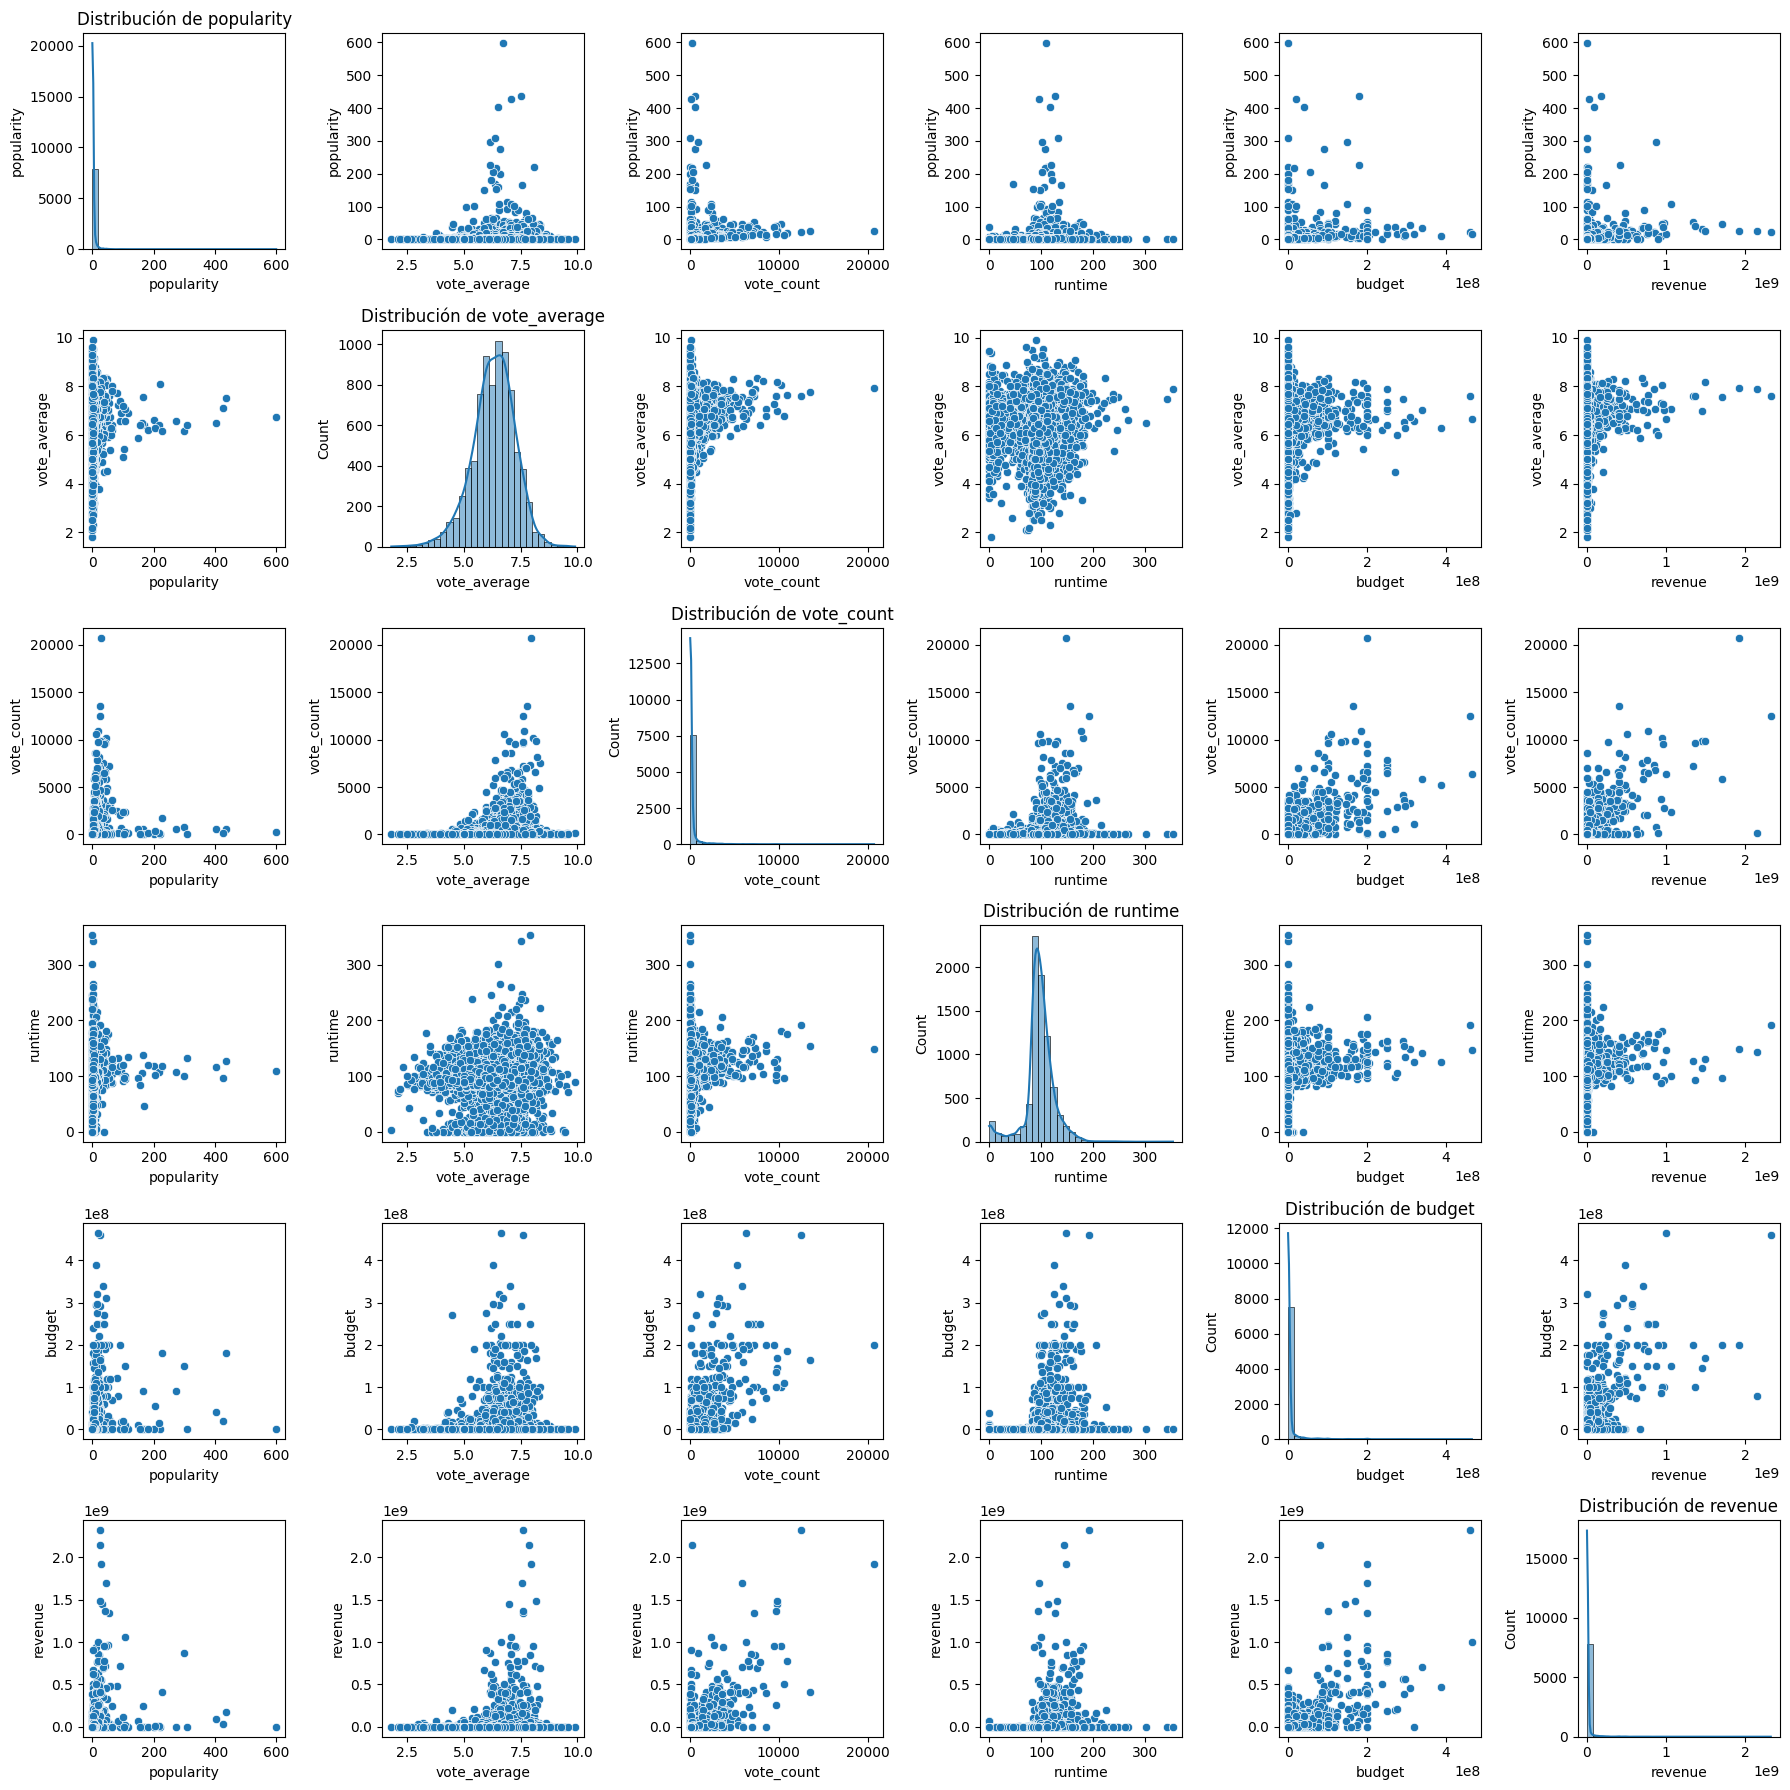

In [40]:
num_vars = len(num_cols)
fig, axes = plt.subplots(nrows=num_vars, ncols=num_vars, figsize=(3 * num_vars, 3 * num_vars))

for i, col1 in enumerate(num_cols):
    for j, col2 in enumerate(num_cols):
        ax = axes[i, j]
        if i == j:
            sns.histplot(df[col1], bins=30, kde=True, ax=ax)
            ax.set_title(f"Distribución de {col1}")
        else:
            sns.scatterplot(x=df[col2], y=df[col1], ax=ax)

        if j == 0:
            ax.set_ylabel(col1)
        if i == num_vars - 1:
            ax.set_xlabel(col2)
plt.tight_layout()
plt.show()

## Some findings
1. There seemes to be correlations present with `vote_count - revenue`, `budget - revenue` and `vote_count - budget`. This could imply a multicollinearity problem.
2. `vote_average` and `runtime` present a correlation as well, though much weaker as the mentioned above.  

In [62]:
multicol_cols: list[str] = ["vote_count", "revenue", "budget"]
multicol_vars = df[multicol_cols]
multicol_vars = add_constant(multicol_vars)
vif = DataFrame()

vif["feature"] = multicol_vars.columns
vif["VIF"] = [
    variance_inflation_factor(multicol_vars.values, i)
    for i in range(multicol_vars.shape[1])
]

In [63]:
vif

,feature,VIF
0,const,1.081031
1,vote_count,2.217110
2,revenue,2.194361
3,budget,2.241744


## Some findings
1. Features do present some level of correlation, however due to they are in the [1, 4) VIF range it's typically not considered severe enough to cause major issues in model estimation or interpretation.

<Axes: >

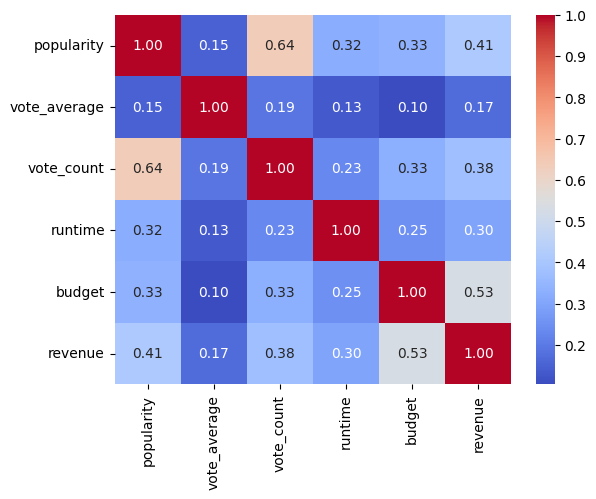

In [48]:
corr_matrix = df[num_cols].corr(method='spearman')  # spearman is chosen do to it's "tolerance" to outliers and measurement of non-linear relationships too.
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")

## Some findings
1. The most outstanding result is the relation between `vote_count` and `popularity`, the most popular movies are the ones voted the most.
2. `budget` and `revenue` have a relationship as well, indicating that movies with more budget tend to receive more revenue.
3. Finally, `revenue` and `popularity` present a connection, implying that movies that are more popular tend to receive more revenue.

# Categorical vs. categorical

In [68]:
cat_cols: list[str] = [
    'release_date',
    'entry_date',
    'original_language',
    'keywords',
    'is_popular',
    'genres',
    'spoken_languages'
]